# Wide and Deep Networks for Credit Score Classification

By: Joe, Sellett, Haiyan Cai, and Cole Wagner

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow import keras
from tensorflow.keras.layers import (
    Activation,
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
)
from tensorflow.keras.utils import FeatureSpace, plot_model


In [2]:
credit_df = pd.read_csv("credit_score_cleaned.csv")

In [3]:
credit_df["payment_behaviour"].value_counts()

payment_behaviour
Low_spent_Small_value_payments      26503
High_spent_Medium_value_payments    18431
Low_spent_Medium_value_payments     14516
High_spent_Large_value_payments     14438
High_spent_Small_value_payments     11850
Low_spent_Large_value_payments      10958
Name: count, dtype: int64

## Data Preparation

### Drop Unnecessary Columns

Before proceeding with the modeling phase of this project, we will remove the following variables: customer_id, name, ssn, and type_of_loan. The customer_id field is being excluded because we already have a more robust unique identifier, id, which will serve as our primary reference for credit score reports. Similarly, name and ssn offer no predictive value and are being dropped to maintain data privacy and reduce dimensionality. Each of these variables contains approximately 8,000–12,000 unique values, whereas id contains over 96,000. Lastly, type_of_loan is being excluded for its high number of categories (50+), which would introduce unnecessary complexity. Instead, we will rely on the credit_mix variable, which summarizes loan diversity in a more manageable form as a category with only 3 unique values (standard, good, and bad).

In [4]:
credit_df = credit_df.drop(
    columns=["customer_id", "name", "ssn", "type_of_loan"]
)

### Create Feature Space for Preprocessing

In [5]:
def create_dataset_from_dataframe(
    x_input: pd.DataFrame, y_input: pd.Series, batch_size: int
) -> tf.data.Dataset:
    """Convert a pandas dataframe to a TensorFlow Dataset.

    Parameters
    ----------
    x_input : pd.DataFrame
        The input pandas dataframe containing the features.
    y_input : pd.Series
        The input pandas series containing the labels.
    batch_size : int
        The number of rows per batch in the TensorFlow Dataset.

    Returns
    -------
    tf.data.Dataset
        A TensorFlow Dataset object created from the input dataframe.

    """
    df_dict = {
        key: value.to_numpy()[:, np.newaxis]
        for key, value in x_input.items()
    }

    tf_ds = tf.data.Dataset.from_tensor_slices((dict(df_dict), y_input))
    tf_ds = tf_ds.batch(batch_size)
    return tf_ds.prefetch(batch_size)


In [6]:
# Sample schema based on the dataframe info
categorical_features = [
    "month",
    "occupation",
    "credit_mix",
    "payment_of_min_amount",
    "payment_behaviour",
]
numeric_features = [
    "age",
    "annual_income",
    "monthly_inhand_salary",
    "credit_history_age",
    "total_emi_per_month",
    "num_bank_accounts",
    "num_credit_card",
    "interest_rate",
    "num_of_loan",
    "delay_from_due_date",
    "num_of_delayed_payment",
    "changed_credit_limit",
    "num_credit_inquiries",
    "outstanding_debt",
    "credit_utilization_ratio",
    "amount_invested_monthly",
    "monthly_balance",
]

# Define feature configs
feature_space = FeatureSpace(
    features={
        **{
            name: FeatureSpace.string_categorical(
                num_oov_indices=0,
                name=name,
            )
            for name in categorical_features
        },
        **{
            name: FeatureSpace.float_normalized(name=name)
            for name in numeric_features
        },
    },
    crosses=[
        FeatureSpace.cross(
            feature_names=("occupation", "credit_mix"),
            crossing_dim=15 * 3,
        ),
        FeatureSpace.cross(
            feature_names=("payment_of_min_amount", "payment_behaviour"),
            crossing_dim=6 * 2,
        ),
    ],
    output_mode="dict",
)

### Cross-Product Feature Justification

First, we created a cross-product feature between `occupation` and `credit_mix`. This combination allows us to capture differences in credit behavior across various professional backgrounds. For example, a neurosurgeon with a bad credit mix may exhibit very different financial behavior compared to an unemployed individual with the same credit mix. While each variable on its own may offer limited insight, their combination provides a more nuanced understanding of how occupation and credit diversity interact.

Another cross-product feature we created combines `payment_of_min_amount` and `payment_behavior`. The `payment_of_min_amount` variable is a binary indicator showing whether an individual made only the minimum payment on their debt for that month. In contrast, `payment_behavior` provides a broader description of a person’s spending and repayment patterns, such as “low spent, high payments” or “high spent, medium payments.” Since these two variables are closely related, their combination may help the model better capture nuanced repayment behaviors and improve its ability to distinguish between risk profiles.

### Performance Metric Justification

Given the nature of our project, it’s important to evaluate our model using multiple metrics rather than relying solely on accuracy. In credit risk classification, false predictions carry different levels of business risk. For example, if a high-risk individual is incorrectly classified as low-risk, the company may absorb the financial loss from a bad loan. This makes recall especially important, as it tells us how well the model identifies actual high-risk cases and helps minimize false negatives. At the same time, precision matters because it reflects how accurate our high-risk predictions are, which ensures we don’t wrongly classify low-risk individuals as high-risk. A high recall means we’re catching most of the truly risky borrowers, while a high precision score means we’re correctly labeling them. Since both metrics are critical and often trade off against each other, we focus on the F1 score, which represents the harmonic mean of precision and recall. The F1 score gives us a more balanced and realistic measure of performance, especially in a setting where both catching risky borrowers and avoiding false alarms are essential to the business.

### Data Splitting

We have chosen to use a standard 80/20 train-test split for dividing our dataset. Given the size of our data (approximately 100,000 observations) we believe this approach is justified and will provide a reliable estimate of model performance. If our dataset were significantly smaller (around 1,000 observations), we might opt for 10-fold cross-validation to obtain a more stable and generalized result. Additionally, the 80/20 split offers a clear advantage in terms of computational efficiency. While 10-fold cross-validation could yield a marginal improvement in performance estimates, it would come at a considerable computational cost that is unnecessary given the scale of our data.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    credit_df.drop(columns=["credit_score", "id"]),
    credit_df["credit_score"],
    test_size=0.2,
    random_state=7324,
    stratify=credit_df["credit_score"],
)

In [8]:
# Convert data to TensorFlow Datasets
train_ds = create_dataset_from_dataframe(x_train, y_train, batch_size=32)
test_ds = create_dataset_from_dataframe(x_test, y_test, batch_size=32)

In [9]:
# Apply feature space to datasets
train_ds_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_no_labels)
processed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)
processed_train_ds = processed_train_ds.prefetch(tf.data.AUTOTUNE)

test_ds_no_labels = test_ds.map(lambda x, _: x)
processed_test_ds = test_ds.map(
    lambda x, y: (feature_space(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)
processed_test_ds = processed_test_ds.prefetch(tf.data.AUTOTUNE)


2025-04-13 18:21:21.154153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 18:21:21.797581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 18:21:23.085809: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 18:21:27.635011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 18:21:37.975201: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Modeling

In [10]:
def setup_embedding_from_encoding(
    encoded_features: dict, col_name: str
) -> tf.Tensor:
    """Set embedding layer from encoded features.

    Parameters
    ----------
    encoded_features : dict
        The encoded features dictionary from the feature space.
    col_name : str
        The name of the column to setup embedding for.

    Returns
    -------
    tf.Tensor
        A TensorFlow tensor representing the embedding layer output.

    """
    # Get the size of the feature
    x = encoded_features[col_name]
    n = x.shape[1]

    # Use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(
        input_dim=n,
        output_dim=int(np.sqrt(n)),
        name=col_name + "_embed",
    )(x)

    return Flatten()(x)


In [11]:
def build_wide_branches(
    encoded_features: dict, crossed_columns: list
) -> tf.Tensor:
    """Build wide branches for crossed columns.

    Parameters.
    ----------
    encoded_features : dict
        The encoded features dictionary from the feature space.
    crossed_columns : list
        The list of crossed column names.

    Returns
    -------
    tf.Tensor
        A TensorFlow tensor representing the concatenated outputs of the wide branches.

    """
    if not crossed_columns:
        return None

    # we need to create separate lists for each branch
    crossed_outputs = []

    # for each crossed variable, make an embedding
    for col in crossed_columns:
        x = setup_embedding_from_encoding(encoded_features, col)

        # save these outputs in list to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    return Concatenate(name="wide_concat")(crossed_outputs)


In [12]:
def build_deep_branches(
    encoded_features: dict,
    hidden_units: list | None = None,
) -> tf.Tensor:
    """Build deep branches for numeric and categorical features.

    Parameters
    ----------
    encoded_features : dict
        A dictionary containing the encoded features from the feature space.
        Each key represents a feature name, and the value is the corresponding
        TensorFlow tensor for that feature.
    hidden_units : list | None, default=None
        A list specifying the number of units in each hidden layer of the deep
        branches. If None, the default structure [64, 32] is used.

    Returns
    -------
        tf.Tensor
            A TensorFlow tensor representing the concatenated outputs of the deep branches.

    """
    # reset this input branch
    if hidden_units is None:
        hidden_units = [64, 32]
    all_deep_branch_outputs = []

    # for each numeric variable, just add it in after embedding
    for col in numeric_features:
        x = encoded_features[col]
        all_deep_branch_outputs.append(x)

    # for each categorical variable
    for col in categorical_features:
        # get the output tensor from ebedding layer
        x = setup_embedding_from_encoding(encoded_features, col)

        # save these outputs in list to concatenate later
        all_deep_branch_outputs.append(x)
    deep_branch = Concatenate(name="embed_concat")(all_deep_branch_outputs)
    i = 1
    for layers in hidden_units:
        name = "deep" + str(i)
        i += 1
        deep_branch = Dense(units=layers, activation="relu", name=name)(
            deep_branch,
        )

    return deep_branch

In [13]:
def build_wide_deep_networks(
    crossed_columns: list[str], hidden_units: list[int] | None = None
) -> keras.Model:
    """Build a wide and deep neural network model.

    Parameters
    ----------
    crossed_columns : list[str]
        List of crossed feature column names for the wide branch.
    hidden_units : list[int] | None, optional
        List of integers specifying the number of units in each hidden layer
        of the deep branch. Defaults to [64, 32] if not provided.

    Returns
    -------
    keras.Model
        A compiled Keras model combining wide and deep branches.

    """
    if hidden_units is None:
        hidden_units = [64, 32]
    dict_inputs = feature_space.get_inputs()
    encoded_features = feature_space.get_encoded_features()
    # these features have been encoded

    wide_branch = build_wide_branches(encoded_features, crossed_columns)
    deep_branch = build_deep_branches(encoded_features, hidden_units)

    # merge the deep and wide branch if it exists
    if wide_branch is not None:
        final_branch = Concatenate(name="concat_deep_wide")(
            [deep_branch, wide_branch]
        )
    else:
        final_branch = Concatenate(name="concat_deep_wide")([deep_branch])

    final_branch = Dense(units=3, activation="softmax", name="combined")(
        final_branch
    )

    # encoded features input, fast
    training_model = keras.Model(
        inputs=encoded_features, outputs=final_branch
    )
    training_model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    training_model.summary()

    # non-encoded, perform redundant operations
    inference_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
    inference_model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return training_model

## Model 1

- Crossed Features: occupation_X_credit_mix

- 2 hidden layers with 64 and 32 units

- Baseline model with a simple cross-product to capture interaction between occupation and credit mix.

In [14]:
crosses = ["occupation_X_credit_mix"]
hidden_units = [64, 32]
model1 = build_wide_deep_networks(crosses, hidden_units)


history = model1.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5> which has name 'keras_tensor_5'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20> which has name 'keras_tensor_20'. Change the tensor name to 'amount_invested_monthly' (via `Input(..., name='amount_invested_monthly')`)
  warnings.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_25CLO… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_26CLO… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_24CLO… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_28CLO… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_27CLO… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_25C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_26C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_24C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_28C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_27C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_5CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_6CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_7CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_8CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_9CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_10CLO… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_11CLO… │ (None, 1)         │          0 │ -               

 Total params: 9,481 (37.04 KB)

 Trainable params: 9,481 (37.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

2418/2418 - 3s - 1ms/step - accuracy: 0.6839 - loss: 0.6931 - val_accuracy: 0.7011 - val_loss: 0.6580
Epoch 2/10
2418/2418 - 2s - 966us/step - accuracy: 0.7033 - loss: 0.6486 - val_accuracy: 0.7068 - val_loss: 0.6459
Epoch 3/10
2418/2418 - 2s - 967us/step - accuracy: 0.7077 - loss: 0.6370 - val_accuracy: 0.7087 - val_loss: 0.6390
Epoch 4/10
2418/2418 - 2s - 958us/step - accuracy: 0.7108 - loss: 0.6298 - val_accuracy: 0.7104 - val_loss: 0.6357
Epoch 5/10
2418/2418 - 2s - 951us/step - accuracy: 0.7128 - loss: 0.6241 - val_accuracy: 0.7112 - val_loss: 0.6344
Epoch 6/10
2418/2418 - 2s - 967us/step - accuracy: 0.7143 - loss: 0.6191 - val_accuracy: 0.7120 - val_loss: 0.6324
Epoch 7/10
2418/2418 - 2s - 948us/step - accuracy: 0.7163 - loss: 0.6148 - val_accuracy: 0.7111 - val_loss: 0.6323
Epoch 8/10
2418/2418 - 2s - 953us/step - accuracy: 0.7178 - loss: 0.6107 - val_accuracy: 0.7114 - val_loss: 0.6314
Epoch 9/10
2418/2418 - 2s - 953us/step - accuracy: 0.7203 - loss: 0.6066 - val_accuracy: 0.71

In [26]:
def plot() -> None:
    """Plot the training and validation loss over epochs.

    This function uses the history object from the model training
    to plot the loss for both training and validation datasets.
    """
    plt.plot(history.history["loss"], label="training")
    plt.plot(history.history["val_loss"], label="validation")
    plt.legend()
    plt.show()


def get_performance(model: keras.Model) -> None:
    """Evaluate the model's performance on the test dataset.

    This function calculates and prints the confusion matrix and
    classification report using sklearn metrics. It uses the
    processed test dataset to make predictions and compare them
    with the true labels.

    Parameters
    ----------
    model : keras.Model
        The trained Keras model to evaluate.

    """
    # we only need to do this to use sklearn metrics
    y_test = tf.concat([y for x, y in processed_test_ds], axis=0).numpy()

    # now lets see how well the model performed
    yhat_proba = model.predict(processed_test_ds)

    yhat = np.argmax(yhat_proba, axis=1)

    # 4. Use sklearn metrics
    print(mt.confusion_matrix(y_test, yhat))
    print(mt.classification_report(y_test, yhat, digits=4))


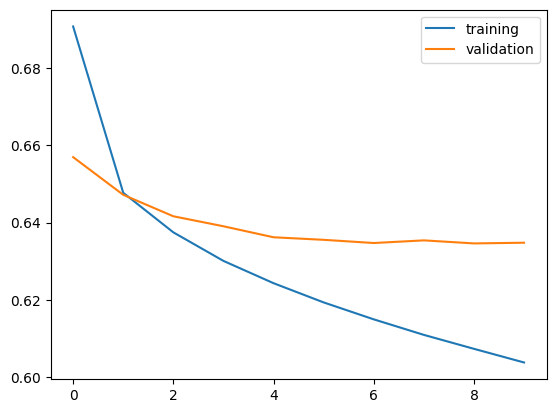

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step
[[3565 1574  358]
 [1256 7738 1307]
 [ 109  948 2485]]
              precision    recall  f1-score   support

           0     0.7231    0.6485    0.6838      5497
           1     0.7542    0.7512    0.7527     10301
           2     0.5988    0.7016    0.6461      3542

    accuracy                         0.7129     19340
   macro avg     0.6920    0.7004    0.6942     19340
weighted avg     0.7169    0.7129    0.7136     19340



In [27]:
plot()
get_performance(model1)

## Model 2

- Crossed Features: occupation_X_credit_mix, payment_of_min_amount_X_payment_behaviour

- 2 hidden layers with 64 and 32 units

- Adds a second crossed feature to explore whether combining payment behavior patterns improves performance.

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5> which has name 'keras_tensor_5'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20> which has name 'keras_tensor_20'. Change the tensor name to 'amount_invested_monthly' (via `Input(..., name='amount_invested_monthly')`)
  warnings.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_25CLO… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_26CLO… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_24CLO… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_28CLO… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_27CLO… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_25C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_26C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_24C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_28C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_27C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_5CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_6CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_7CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_8CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_9CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_10CLO… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_11CLO… │ (None, 1)         │          0 │ -               

 Total params: 9,625 (37.60 KB)

 Trainable params: 9,625 (37.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

2418/2418 - 4s - 1ms/step - accuracy: 0.6830 - loss: 0.6919 - val_accuracy: 0.6998 - val_loss: 0.6552
Epoch 2/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7028 - loss: 0.6469 - val_accuracy: 0.7041 - val_loss: 0.6433
Epoch 3/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7071 - loss: 0.6365 - val_accuracy: 0.7056 - val_loss: 0.6387
Epoch 4/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7109 - loss: 0.6295 - val_accuracy: 0.7089 - val_loss: 0.6367
Epoch 5/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7144 - loss: 0.6234 - val_accuracy: 0.7082 - val_loss: 0.6352
Epoch 6/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7160 - loss: 0.6185 - val_accuracy: 0.7083 - val_loss: 0.6344
Epoch 7/10
2418/2418 - 2s - 995us/step - accuracy: 0.7168 - loss: 0.6142 - val_accuracy: 0.7093 - val_loss: 0.6338
Epoch 8/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7191 - loss: 0.6100 - val_accuracy: 0.7107 - val_loss: 0.6322
Epoch 9/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7207 - loss: 0.6064 - val_accuracy: 0.7101 - val_loss:

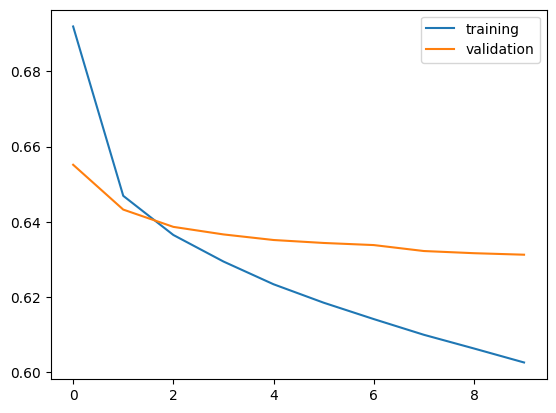

126/605 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step
[[3531 1625  341]
 [1214 7796 1291]
 [ 112 1036 2394]]
              precision    recall  f1-score   support

           0     0.7270    0.6424    0.6821      5497
           1     0.7455    0.7568    0.7511     10301
           2     0.5946    0.6759    0.6327      3542

    accuracy                         0.7095     19340
   macro avg     0.6891    0.6917    0.6886     19340
weighted avg     0.7126    0.7095    0.7098     19340



In [28]:
crosses = [
    "occupation_X_credit_mix",
    "payment_of_min_amount_X_payment_behaviour",
]
hidden_units = [64, 32]
model2 = build_wide_deep_networks(crosses, hidden_units)


history = model2.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)

plot()
get_performance(model=model2)

## Model 3

- Crossed Features: occupation_X_credit_mix, payment_of_min_amount_X_payment_behaviour

- 3 hidden layers with 128, 64, and 32

- add one more layer with 128 neurals to explore whether deeper networks improves performance.

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5> which has name 'keras_tensor_5'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20> which has name 'keras_tensor_20'. Change the tensor name to 'amount_invested_monthly' (via `Input(..., name='amount_invested_monthly')`)
  warnings.

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_25CLO… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_26CLO… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_24CLO… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_28CLO… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_27CLO… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_25C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_26C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_24C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_28C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_27C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_5CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_6CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_7CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_8CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_9CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_10CLO… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_11CLO… │ (None, 1)         │          0 │ -               

 Total params: 24,025 (93.85 KB)

 Trainable params: 24,025 (93.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

2418/2418 - 4s - 2ms/step - accuracy: 0.6905 - loss: 0.6777 - val_accuracy: 0.7061 - val_loss: 0.6465
Epoch 2/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7070 - loss: 0.6393 - val_accuracy: 0.7068 - val_loss: 0.6404
Epoch 3/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7107 - loss: 0.6281 - val_accuracy: 0.7101 - val_loss: 0.6344
Epoch 4/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7147 - loss: 0.6185 - val_accuracy: 0.7121 - val_loss: 0.6308
Epoch 5/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7185 - loss: 0.6089 - val_accuracy: 0.7127 - val_loss: 0.6277
Epoch 6/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7234 - loss: 0.5990 - val_accuracy: 0.7130 - val_loss: 0.6262
Epoch 7/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7290 - loss: 0.5882 - val_accuracy: 0.7137 - val_loss: 0.6234
Epoch 8/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7341 - loss: 0.5774 - val_accuracy: 0.7155 - val_loss: 0.6216
Epoch 9/10
2418/2418 - 3s - 1ms/step - accuracy: 0.7393 - loss: 0.5662 - val_accuracy: 0.7177 - val_loss: 0

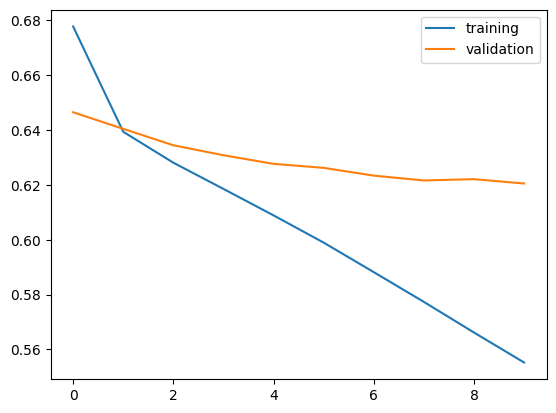

138/605 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step
[[3705 1457  335]
 [1258 7736 1307]
 [ 109  946 2487]]
              precision    recall  f1-score   support

           0     0.7305    0.6740    0.7011      5497
           1     0.7630    0.7510    0.7569     10301
           2     0.6023    0.7021    0.6484      3542

    accuracy                         0.7202     19340
   macro avg     0.6986    0.7090    0.7022     19340
weighted avg     0.7243    0.7202    0.7212     19340



In [29]:
crosses = [
    "occupation_X_credit_mix",
    "payment_of_min_amount_X_payment_behaviour",
]

hidden_units = [128, 64, 32]

model3 = build_wide_deep_networks(crosses, hidden_units)


history = model3.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)
plot()
get_performance(model=model3)

### Analysis

From the visualization for Model1, Model2, and Model3, we can see that:
- overall, model3 achieved the best generalization performance compared with model1 and model2. model3 added one more layer, indicating the deeper network provides better generalization
- Model 2 outperforms Model 1 across all metrics, indicating that adding crossed feature(payment_of_min_amount and payment_behaviour) did helped memorization on capturing more patterns.

## standard multi-layer perceptron (MLP)

- Crossed Features: none; no wide branch 

- 2 hidden layers with 64, and 32

- compare MLP with model 3

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5> which has name 'keras_tensor_5'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'amount_invested_monthly' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20> which has name 'keras_tensor_20'. Change the tensor name to 'amount_invested_monthly' (via `Input(..., name='amount_invested_monthly')`)
  warnings.

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_25CLO… │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_26CLO… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_24CLO… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_28CLO… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_27CLO… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month_embed         │ (None, 8, 2)      │         16 │ keras_tensor_25C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occupation_embed    │ (None, 15, 3)     │         45 │ keras_tensor_26C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ credit_mix_embed    │ (None, 3, 1)      │          3 │ keras_tensor_24C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_of_min_amo… │ (None, 2, 1)      │          2 │ keras_tensor_28C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_behaviour_… │ (None, 6, 2)      │         12 │ keras_tensor_27C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_5CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_6CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_7CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_8CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_9CLONE │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_10CLO… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_11CLO… │ (None, 1)         │          0 │ -               

 Total params: 22,801 (89.07 KB)

 Trainable params: 22,801 (89.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

2418/2418 - 3s - 1ms/step - accuracy: 0.6914 - loss: 0.6794 - val_accuracy: 0.7030 - val_loss: 0.6486
Epoch 2/10
2418/2418 - 2s - 999us/step - accuracy: 0.7071 - loss: 0.6390 - val_accuracy: 0.7068 - val_loss: 0.6408
Epoch 3/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7122 - loss: 0.6256 - val_accuracy: 0.7097 - val_loss: 0.6356
Epoch 4/10
2418/2418 - 2s - 998us/step - accuracy: 0.7164 - loss: 0.6146 - val_accuracy: 0.7099 - val_loss: 0.6319
Epoch 5/10
2418/2418 - 2s - 988us/step - accuracy: 0.7220 - loss: 0.6035 - val_accuracy: 0.7105 - val_loss: 0.6306
Epoch 6/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7281 - loss: 0.5916 - val_accuracy: 0.7122 - val_loss: 0.6278
Epoch 7/10
2418/2418 - 2s - 978us/step - accuracy: 0.7341 - loss: 0.5799 - val_accuracy: 0.7161 - val_loss: 0.6246
Epoch 8/10
2418/2418 - 2s - 988us/step - accuracy: 0.7404 - loss: 0.5678 - val_accuracy: 0.7167 - val_loss: 0.6206
Epoch 9/10
2418/2418 - 2s - 1ms/step - accuracy: 0.7477 - loss: 0.5554 - val_accuracy: 0.7188 - v

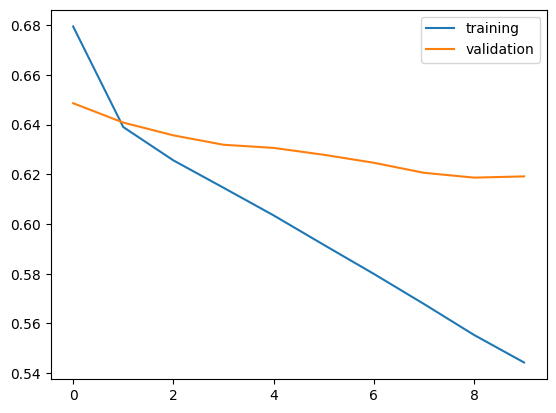

220/605 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'age': 'keras_tensor_5CLONE', 'amount_invested_monthly': 'keras_tensor_20CLONE', 'annual_income': 'keras_tensor_6CLONE', 'changed_credit_limit': 'keras_tensor_16CLONE', 'credit_history_age': 'keras_tensor_8CLONE', 'credit_mix': 'keras_tensor_24CLONE', 'credit_utilization_ratio': 'keras_tensor_19CLONE', 'delay_from_due_date': 'keras_tensor_14CLONE', 'interest_rate': 'keras_tensor_12CLONE', 'month': 'keras_tensor_25CLONE', 'monthly_balance': 'keras_tensor_21CLONE', 'monthly_inhand_salary': 'keras_tensor_7CLONE', 'num_bank_accounts': 'keras_tensor_10CLONE', 'num_credit_card': 'keras_tensor_11CLONE', 'num_credit_inquiries': 'keras_tensor_17CLONE', 'num_of_delayed_payment': 'keras_tensor_15CLONE', 'num_of_loan': 'keras_tensor_13CLONE', 'occupation': 'keras_tensor_26CLONE', 'occupation_X_credit_mix

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step
[[3779 1378  340]
 [1374 7562 1365]
 [  95  904 2543]]
              precision    recall  f1-score   support

           0     0.7201    0.6875    0.7034      5497
           1     0.7682    0.7341    0.7508     10301
           2     0.5986    0.7180    0.6529      3542

    accuracy                         0.7179     19340
   macro avg     0.6956    0.7132    0.7023     19340
weighted avg     0.7235    0.7179    0.7194     19340



In [30]:
crosses = []

hidden_units = [128, 64, 32]

basic_model = build_wide_deep_networks(crosses, hidden_units)


history = basic_model.fit(
    processed_train_ds,
    epochs=10,
    validation_data=processed_test_ds,
    verbose=2,
)
plot()
get_performance(model=basic_model)

### Analysis

Compared with Model3, we can see that:
- The standard MLP has the same hidden layer structure ([128, 64, 32]) as model 3 but does not include a wide branch. However,the standarded MLP achieved similar performance to model3. This means that the deep branch alone was able to learn the relevant feature interactions from the data without needing explicitly crossed features.

### McNemar's Test

In [31]:
def mcnemar_test(model1: keras.Model, model2: keras.Model) -> None:
    """Perform McNemar's test to compare two models.

    Parameters
    ----------
    model1 : keras.Model
        The first Keras model to compare.
    model2 : keras.Model
        The second Keras model to compare.

    Returns
    -------
    None
        Prints the results of the McNemar's test.

    """
    yhat1_proba = model1.predict(processed_test_ds)
    yhat1 = np.argmax(yhat1_proba, axis=1)

    yhat2_proba = model2.predict(processed_test_ds)
    yhat2 = np.argmax(yhat2_proba, axis=1)

    # Create a contingency table
    contingency_table = pd.crosstab(
        pd.Series(yhat1, name="Model 1"),
        pd.Series(yhat2, name="Model 2"),
    )

    # Perform McNemar's test
    result = mcnemar(contingency_table, exact=True)

    print("McNemar's Test Results:")
    print(f"Statistic: {result.statistic}")
    print(f"P-value: {result.pvalue}")

In [32]:
mcnemar_test(model1, model2)
mcnemar_test(model2, model3)
mcnemar_test(model3, basic_model)

605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step
McNemar's Test Results:
Statistic: 391.0
P-value: 0.0011914307466141683
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step
McNemar's Test Results:
Statistic: 456.0
P-value: 1.3221665984899933e-06
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step
McNemar's Test Results:
Statistic: 560.0
P-value: 4.966592344468156e-11
